# SPARC-4 mini-pipeline tools
***

This notebook shows an example for reducing the SPARC4 data using the SPARC4 pipeline tools.

* Eder Martioli, LNA 24 Nov 2023

In [1]:
import os, sys
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.params as params
import sparc4.utils as s4utils
import glob

## User inputs and initial setup

In [2]:
# set night directory name
NIGHTDIR = '20230606'
# set raw data root directory
ROOTDATADIR =  "/Volumes/Samsung_T5/Data/SPARC4/minidata/"
# set reduced data root directory
ROOTREDUCEDDIR = "/Volumes/Samsung_T5/Data/SPARC4/minidata/reduced/"
# set reduced data root directory
PIPELINEDIR = "/Volumes/Samsung_T5/sparc4-pipeline/"

# set SPARC4 channel
CHANNEL = 1  # 1, 2, 3 or 4

# build directory paths
datadir = "{}/sparc4acs{}/{}".format(ROOTDATADIR,CHANNEL,NIGHTDIR)
reducedir = "{}/sparc4acs{}/{}".format(ROOTREDUCEDDIR,CHANNEL,NIGHTDIR)

# if reduced dir doesn't exist create one
os.makedirs(reducedir, exist_ok=True)

# load SPARC4 parameters
p = params.load_sparc4_parameters()

# define path to default calibration directory
calibdb_dir = os.path.join(PIPELINEDIR, "calibdb/")

# set astrometry ref image as the one for this channel
p["ASTROM_REF_IMG"] = os.path.join(calibdb_dir, p["ASTROM_REF_IMGS"][CHANNEL-1])

# to force reduction even if products already exist
FORCE = False

***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

## Define input list and output product file names

In [3]:
# create a list of zeros for current detector mode
zero_list = glob.glob("{}/{}".format(datadir,"*zero*.fits"))

# define file name of master bias 
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# create a list of flats for current detector mode
flat_list = glob.glob("{}/{}".format(datadir,"*dflat*.fits"))

# define file name of master flat
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reducedir,
                                                   NIGHTDIR,
                                                   CHANNEL)

# Run master calibration

In [4]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     force=FORCE)

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:

bias files: 3
gain: 3.37 electron / adu
processing frame 1 of 3
processing frame 2 of 3


2023-11-24 14:49:27,786 astropop - INFO - Combining 3 images with median method.  [imcombine]


processing frame 3 of 3
Normalization mean value: 1696.8556009674066 electron


In [5]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     normalize=True, 
                                     force=FORCE)

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:

flat files: 3
gain: 3.37 electron / adu
processing frame 1 of 3
processing frame 2 of 3


2023-11-24 14:49:28,696 astropop - INFO - Combining 3 images with median method.  [imcombine]


processing frame 3 of 3
Normalization mean value: 42023.73166647912 electron


2023-11-24 14:49:28,846 astropy - WARNING - VerifyWarning: Keyword name 'astropop imcombine nimages' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:28,847 astropy - WARNING - VerifyWarning: Keyword name 'astropop imcombine method' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]


# Plot results

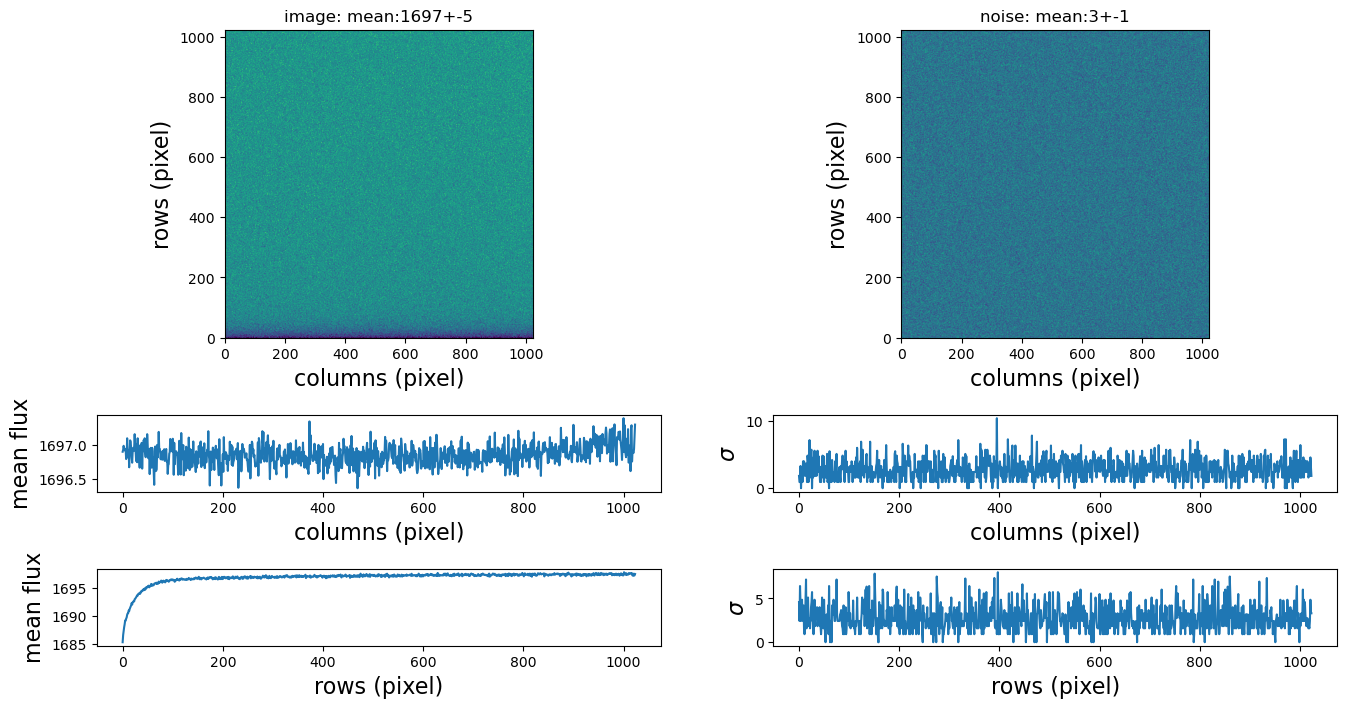

In [6]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

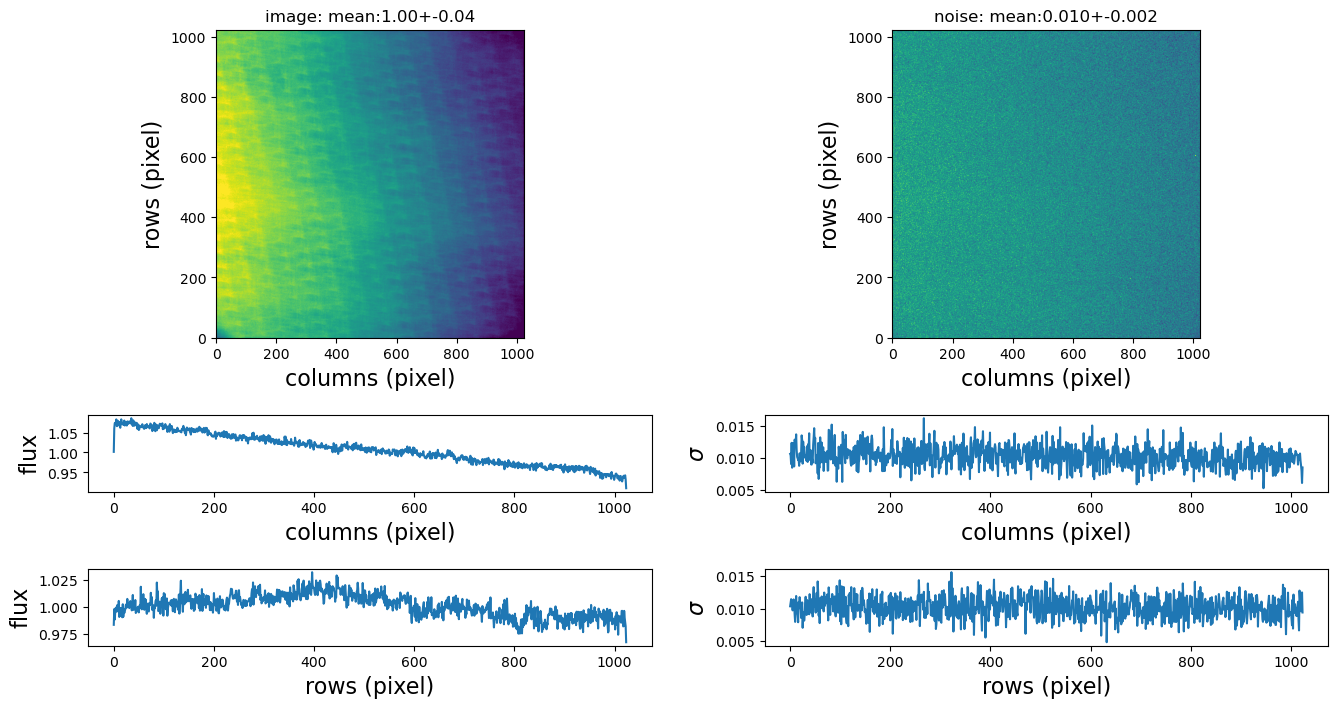

In [7]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)

***
# <font color='darkblue'>Science image reduction</font> 

## Reduce scientific exposures in `PHOTOMETRIC` mode

In [8]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "ltt4816"  # LTT 4816 is a spectro-photometric standard

In [9]:
# set suffix for output stack filename
stack_suffix = "{}_s4c{}_{}".format(NIGHTDIR, 
                                    CHANNEL, 
                                    OBJECTID.replace(" ",""))
# create a list of science data 
sci_list = glob.glob("{}/{}".format(datadir,"*ltt4816.fits"))

In [10]:
sci_list, stack_suffix

(['/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000012_ltt4816.fits',
  '/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000015_ltt4816.fits',
  '/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000014_ltt4816.fits',
  '/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000013_ltt4816.fits',
  '/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000009_ltt4816.fits',
  '/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000011_ltt4816.fits',
  '/Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000010_ltt4816.fits'],
 '20230606_s4c1_ltt4816')

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison 

2 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000014_ltt4816.fits
OBJECT files: 7
Loading science frames to memory ... 
gain: 3.37 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 7 : 20230606_s4c1_000014_ltt4816.fits 


/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
2023-11-24 14:49:38,254 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:38,255 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:38,256 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater th

Calibrating science frame 2 of 7 : 20230606_s4c1_000015_ltt4816.fits 


2023-11-24 14:49:38,643 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:38,644 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:38,645 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:38,800 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:38,802 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 3 of 7 : 20230606_s4c1_000011_ltt4816.fits 


2023-11-24 14:49:39,043 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,044 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,045 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,186 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,187 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 4 of 7 : 20230606_s4c1_000009_ltt4816.fits 


2023-11-24 14:49:39,430 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,431 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,432 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,570 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,571 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 5 of 7 : 20230606_s4c1_000013_ltt4816.fits 


2023-11-24 14:49:39,802 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,803 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,804 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,945 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:39,946 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 6 of 7 : 20230606_s4c1_000010_ltt4816.fits 


2023-11-24 14:49:40,181 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,182 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,183 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,334 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,336 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 7 of 7 : 20230606_s4c1_000012_ltt4816.fits 


2023-11-24 14:49:40,572 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,573 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,574 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,723 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:49:40,724 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000014_ltt4816.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000015_ltt4816.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000011_ltt4816.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000009_ltt4816.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000013_ltt4816.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000010_ltt4816.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000012_ltt4816.fits


2023-11-24 14:49:40,942 astropop - INFO - Registering image with: translation=[-0.25 -0.25], rotation=0.00°  [register]
2023-11-24 14:49:41,077 astropop - INFO - Registering image 3 from 7  [register]
2023-11-24 14:49:41,183 astropop - INFO - Filling registered image with cval=117.29  [register]
2023-11-24 14:49:41,188 astropop - INFO - Registering image with: translation=[-0.25 -0.25], rotation=0.00°  [register]
2023-11-24 14:49:41,348 astropop - INFO - Registering image 4 from 7  [register]
2023-11-24 14:49:41,460 astropop - INFO - Filling registered image with cval=118.94  [register]
2023-11-24 14:49:41,467 astropop - INFO - Registering image with: translation=[-0.25  0.5 ], rotation=0.00°  [register]
2023-11-24 14:49:41,604 astropop - INFO - Registering image 5 from 7  [register]
2023-11-24 14:49:41,707 astropop - INFO - Filling registered image with cval=115.38  [register]
2023-11-24 14:49:41,723 astropop - INFO - Registering image with: translation=[-1.5  -0.25], rotation=0.00°  

Creating new catalog of detected sources:
Running photometry for multiple apertures:
Aperture radius of 5 pixels: 1 of 16 :
Aperture radius of 6 pixels: 2 of 16 :
Aperture radius of 7 pixels: 3 of 16 :
Aperture radius of 8 pixels: 4 of 16 :
Aperture radius of 9 pixels: 5 of 16 :
Aperture radius of 10 pixels: 6 of 16 :
Aperture radius of 11 pixels: 7 of 16 :
Aperture radius of 12 pixels: 8 of 16 :
Aperture radius of 13 pixels: 9 of 16 :
Aperture radius of 14 pixels: 10 of 16 :
Aperture radius of 15 pixels: 11 of 16 :
Aperture radius of 16 pixels: 12 of 16 :
Aperture radius of 17 pixels: 13 of 16 :
Aperture radius of 18 pixels: 14 of 16 :
Aperture radius of 19 pixels: 15 of 16 :
Aperture radius of 20 pixels: 16 of 16 :


2023-11-24 14:49:46,241 astropy - WARNING - TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days  [logger]
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perfor

The 7 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 7 ... 
OBJECT files: 7
Creating output list of processed science frames ... 
1 of 7 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000012_ltt4816_proc.fits
2 of 7 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000015_ltt4816_proc.fits
3 of 7 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000014_ltt4816_proc.fits
4 of 7 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000013_ltt4816_proc.fits
5 of 7 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000009_ltt4816_proc.fits
6 of 7 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000011_ltt4816_proc.fits
7 of 7 is reduced? True -> /Users/eder/Data/SPA

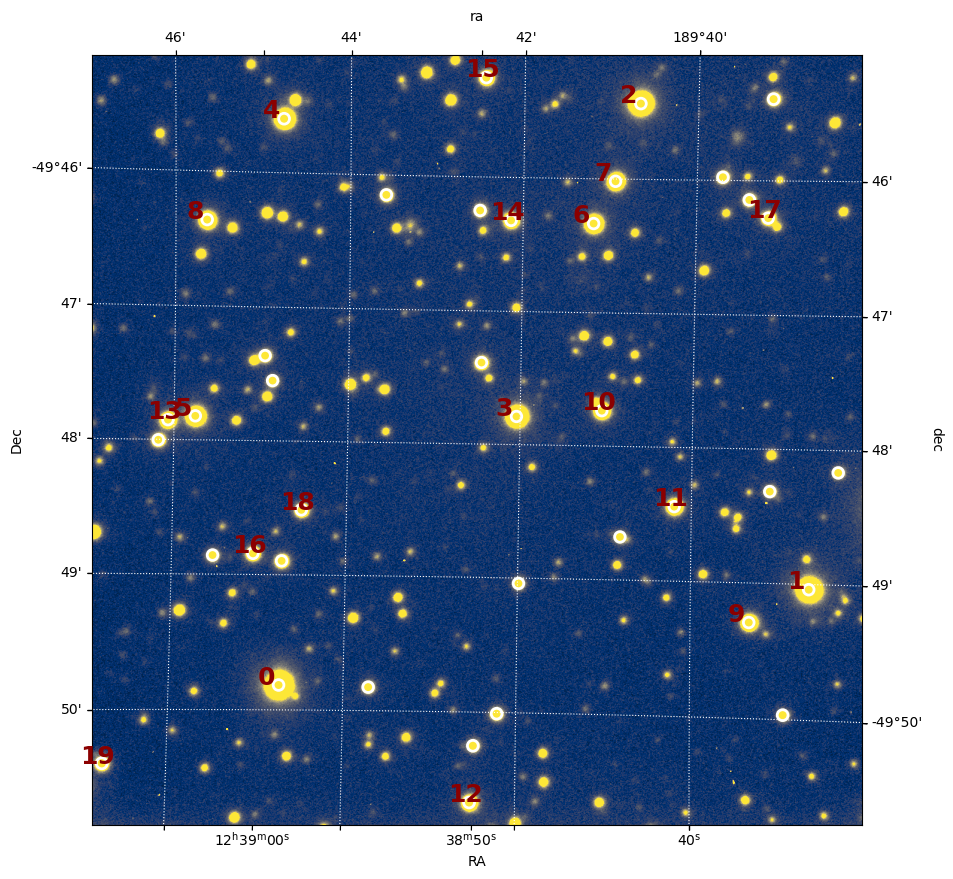

In [11]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          sci_list,
                                          reducedir,
                                          stack_suffix=stack_suffix,
                                          force=FORCE,
                                          verbose=True,
                                          plot=True) 

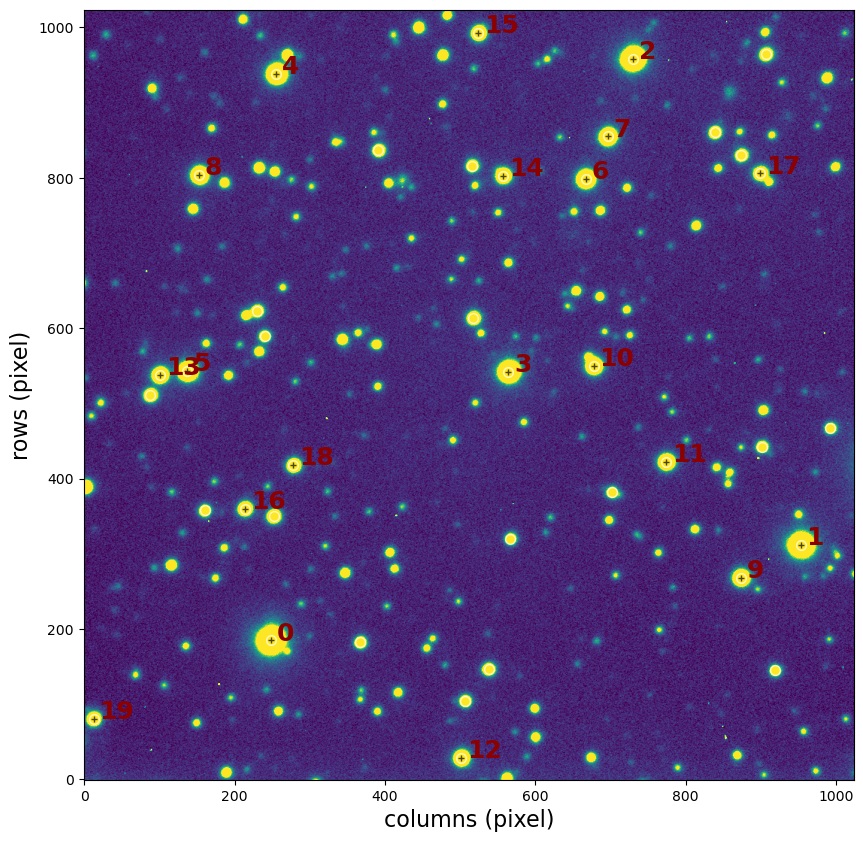

In [12]:
s4plt.plot_sci_frame(p['OBJECT_STACK'], cat_ext=3, nstars=20, use_sky_coords=False)

In [14]:
ts_suffix = "{}_s4c{}_{}".format(NIGHTDIR, CHANNEL, OBJECTID.replace(" ",""))

list_of_catalogs = s4pipelib.get_list_of_catalogs(p['PHOT_APERTURES_FOR_LIGHTCURVES'])

phot_ts_product = s4pipelib.phot_time_series(p['OBJECT_REDUCED_IMAGES'][1:],
                                             ts_suffix=ts_suffix,
                                             reduce_dir=reducedir,
                                             time_key=p['TIME_KEYWORD_IN_PROC'],
                                             time_format=p['TIME_FORMAT_IN_PROC'],
                                             catalog_names=list_of_catalogs,
                                             time_span_for_rms=p['TIME_SPAN_FOR_RMS'],
                                             force=FORCE)

Packing time series data for catalog: CATALOG_PHOT_AP005
Packing time series data for catalog: CATALOG_PHOT_AP006
Packing time series data for catalog: CATALOG_PHOT_AP007
Packing time series data for catalog: CATALOG_PHOT_AP008
Packing time series data for catalog: CATALOG_PHOT_AP009
Packing time series data for catalog: CATALOG_PHOT_AP010
Packing time series data for catalog: CATALOG_PHOT_AP011
Packing time series data for catalog: CATALOG_PHOT_AP012
Packing time series data for catalog: CATALOG_PHOT_AP013
Packing time series data for catalog: CATALOG_PHOT_AP014
Packing time series data for catalog: CATALOG_PHOT_AP015
Packing time series data for catalog: CATALOG_PHOT_AP016
Packing time series data for catalog: CATALOG_PHOT_AP017
Packing time series data for catalog: CATALOG_PHOT_AP018
Packing time series data for catalog: CATALOG_PHOT_AP019
Packing time series data for catalog: CATALOG_PHOT_AP020


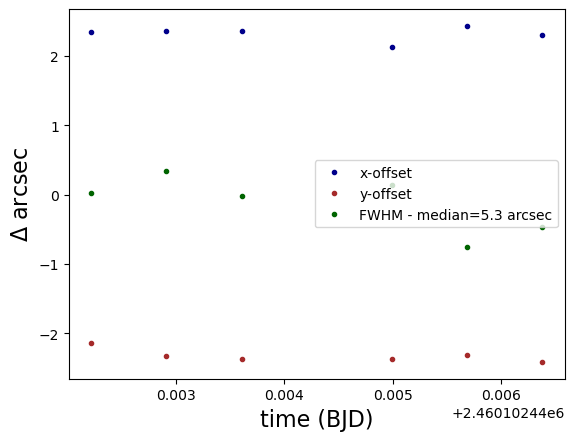

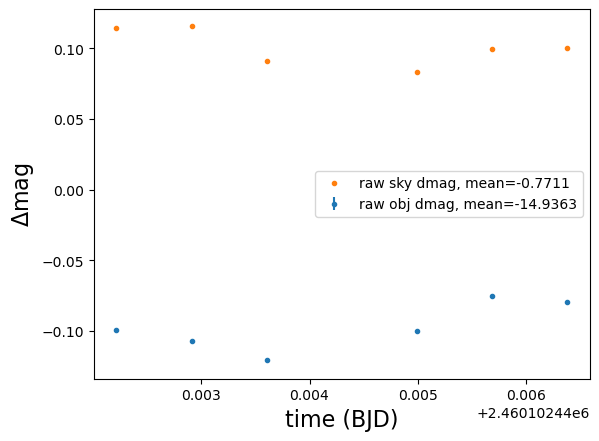

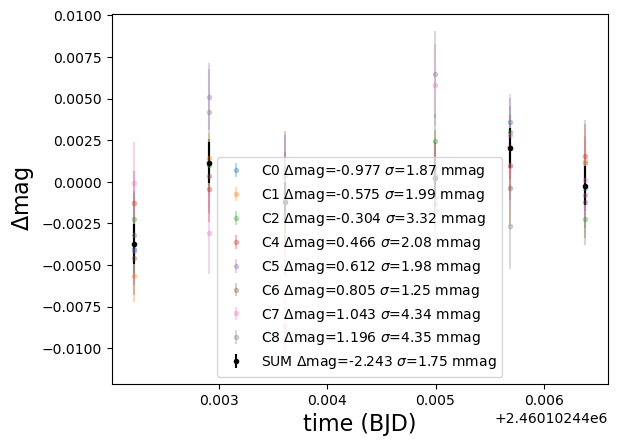

In [15]:
# Select target index
target = 3
# Select comparisons 
comps = [0, 1, 2, 4, 5, 6, 7, 8]

# plot light curve
s4plt.plot_light_curve(phot_ts_product,
                       target=target,
                       comps=comps,
                       nsig=10,
                       plot_coords=True,
                       plot_rawmags=True,
                       plot_sum=True,
                       plot_comps=True,
                       catalog_name=p['PHOT_REF_CATALOG_NAME'])

***
# <font color='darkblue'>Polarimetry</font> 

In [16]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "hd111579" # HD111579 is a polarimetric standard

# create a list of science data 
pol_list = glob.glob("{}/{}".format(datadir,"*stdpol.fits"))

# set instrument mode to "POLAR"
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']

FORCE = False

## Reduce scientific exposures in `POLARIMETRY HALF-WAVE` mode

In [17]:
# initial set up
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l2_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of half-wave files (L2)
pol_l2_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L2')

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')


14 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000034_stdpol.fits
OBJECT files: 16
Loading science frames to memory ... 
gain: 3.37 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 16 : 20230606_s4c1_000034_stdpol.fits 


/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:

Calibrating science frame 2 of 16 : 20230606_s4c1_000033_stdpol.fits 


2023-11-24 14:51:47,583 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:47,585 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:47,586 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:47,781 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:47,783 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 3 of 16 : 20230606_s4c1_000024_stdpol.fits 


2023-11-24 14:51:48,027 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,028 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,029 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,174 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,176 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 4 of 16 : 20230606_s4c1_000022_stdpol.fits 


2023-11-24 14:51:48,409 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,410 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,412 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,552 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,553 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 5 of 16 : 20230606_s4c1_000021_stdpol.fits 


2023-11-24 14:51:48,796 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,797 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,799 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,937 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:48,939 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 6 of 16 : 20230606_s4c1_000020_stdpol.fits 


2023-11-24 14:51:49,163 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,164 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,165 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,309 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,310 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 7 of 16 : 20230606_s4c1_000023_stdpol.fits 


2023-11-24 14:51:49,546 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,547 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,548 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,683 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,685 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 8 of 16 : 20230606_s4c1_000026_stdpol.fits 


2023-11-24 14:51:49,908 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,909 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:49,910 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,050 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,052 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 9 of 16 : 20230606_s4c1_000027_stdpol.fits 


2023-11-24 14:51:50,277 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,278 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,280 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,415 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,416 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 10 of 16 : 20230606_s4c1_000019_stdpol.fits 


2023-11-24 14:51:50,649 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,650 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,651 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,784 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:50,786 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 11 of 16 : 20230606_s4c1_000031_stdpol.fits 


2023-11-24 14:51:51,013 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,014 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,016 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,147 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,148 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 12 of 16 : 20230606_s4c1_000030_stdpol.fits 


2023-11-24 14:51:51,386 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,387 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,388 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,521 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,522 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 13 of 16 : 20230606_s4c1_000025_stdpol.fits 


2023-11-24 14:51:51,754 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,755 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,756 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,888 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:51,890 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 14 of 16 : 20230606_s4c1_000032_stdpol.fits 


2023-11-24 14:51:52,113 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,114 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,115 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,247 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,248 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 15 of 16 : 20230606_s4c1_000029_stdpol.fits 


2023-11-24 14:51:52,481 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,483 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,484 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,624 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,625 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 16 of 16 : 20230606_s4c1_000028_stdpol.fits 


2023-11-24 14:51:52,858 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,859 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,860 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,993 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:51:52,995 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000034_stdpol.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000033_stdpol.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000024_stdpol.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000022_stdpol.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000021_stdpol.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000020_stdpol.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000023_stdpol.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000026_stdpol.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000027_stdpol.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000019_stdpol.fits
10 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/202

2023-11-24 14:51:53,223 astropop - INFO - Filling registered image with cval=9.97  [register]
2023-11-24 14:51:53,223 astropop - INFO - Registering image with: translation=[ 0.25 -0.75], rotation=0.00°  [register]
2023-11-24 14:51:53,363 astropop - INFO - Registering image 3 from 16  [register]
2023-11-24 14:51:53,511 astropop - INFO - Filling registered image with cval=9.93  [register]
2023-11-24 14:51:53,528 astropop - INFO - Registering image with: translation=[-1.5   0.75], rotation=0.00°  [register]
2023-11-24 14:51:53,678 astropop - INFO - Registering image 4 from 16  [register]
2023-11-24 14:51:53,810 astropop - INFO - Filling registered image with cval=9.85  [register]
2023-11-24 14:51:53,816 astropop - INFO - Registering image with: translation=[-0.25  1.  ], rotation=0.00°  [register]
2023-11-24 14:51:53,969 astropop - INFO - Registering image 5 from 16  [register]
2023-11-24 14:51:54,084 astropop - INFO - Filling registered image with cval=9.82  [register]
2023-11-24 14:51:5

Creating new catalog of detected sources:
Running photometry for multiple apertures:
Aperture radius of 5 pixels: 1 of 16 :
Aperture radius of 6 pixels: 2 of 16 :
Aperture radius of 7 pixels: 3 of 16 :
Aperture radius of 8 pixels: 4 of 16 :
Aperture radius of 9 pixels: 5 of 16 :
Aperture radius of 10 pixels: 6 of 16 :
Aperture radius of 11 pixels: 7 of 16 :
Aperture radius of 12 pixels: 8 of 16 :
Aperture radius of 13 pixels: 9 of 16 :
Aperture radius of 14 pixels: 10 of 16 :
Aperture radius of 15 pixels: 11 of 16 :
Aperture radius of 16 pixels: 12 of 16 :
Aperture radius of 17 pixels: 13 of 16 :
Aperture radius of 18 pixels: 14 of 16 :


2023-11-24 14:52:00,190 astropy - WARNING - TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days  [logger]


Aperture radius of 19 pixels: 15 of 16 :
Aperture radius of 20 pixels: 16 of 16 :
The 16 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000026_stdpol_proc.fits
2 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000033_stdpol_proc.fits
3 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000023_stdpol_proc.fits
4 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000020_stdpol_proc.fits
5 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000029_stdpol_proc.fits
6 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison 

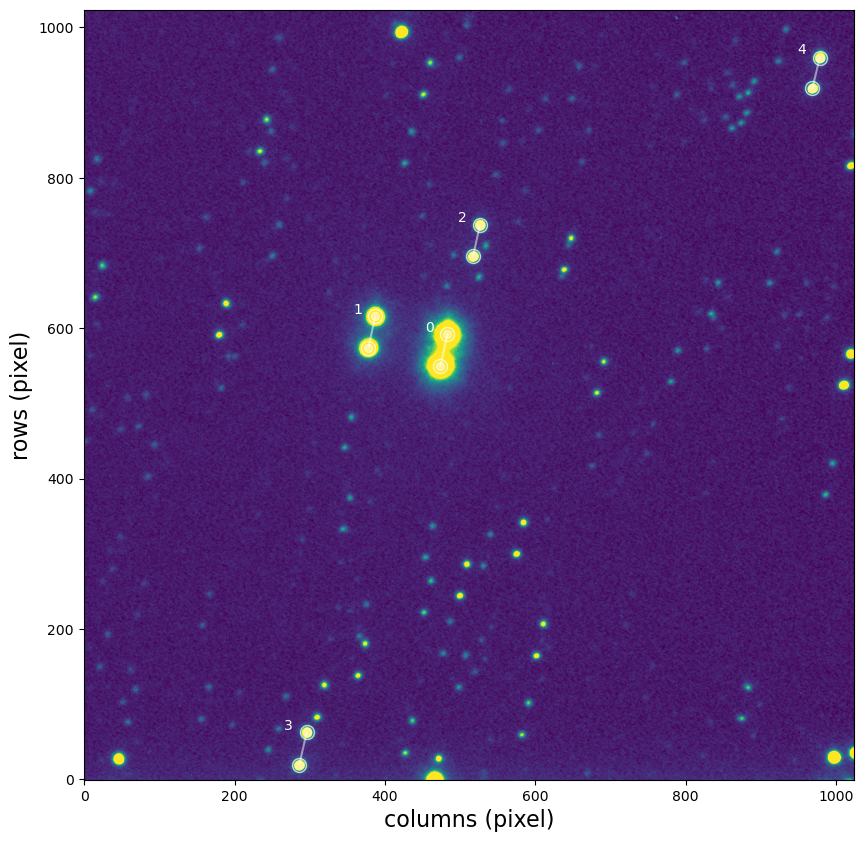

In [18]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l2_list,
                                          reducedir,
                                          stack_suffix=l2_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          verbose=True,
                                          plot=True) 

## Calculate `HALF-WAVE` POLARIMETRY

In [19]:
# input reduced files list
red_pol_l2_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l2_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l2_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


There is already a polarimetry product : /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000019_stdpol_l2_polar.fits
Source index: i=0 
Source RA=280.2125136253325 Dec=-6.774785997683465 mag=-19.1562+-0.0002
Best aperture radius: 11.0 pixels
Polarization in Q: -0.0230+-0.0007
Polarization in U: -0.0571+-0.0008


/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/math/physical.py:99: RuntimeWarning: invalid value encountered in cast
  return -np.int_(np.floor(np.log10(np.abs(std)))) + sig - 1
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/math/physical.py:99: RuntimeWarning: divide by zero encountered in log10
  return -np.int_(np.floor(np.log10(np.abs(std)))) + sig - 1
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/math/physical.py:99: RuntimeWarning: overflow encountered in scalar negative
  return -np.int_(np.floor(np.log10(np.abs(std)))) + sig - 1
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Polarization in V: nan+-nan
Total linear polarization p: 0.0616+-0.0008
Angle of polarization theta: 124.0+-0.4
Free constant k: 1+-nan
Zero of polarization: 0.0+-0.0
RMS of zi residuals: 0.00066
Reduced chi-square (n=16.0, DOF=14.0): 12.85


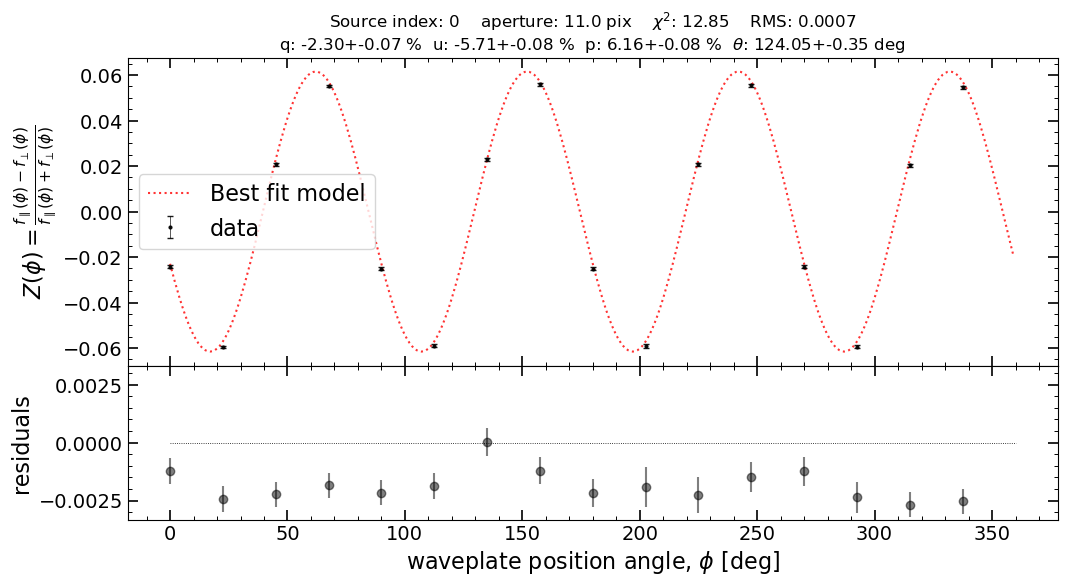

In [20]:
l2_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key = 'WPPOS',
                                                 wave_plate = 'halfwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = True,
                                                 fit_zero = False,
                                                 force = FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    
    l2_polar_products.append(polarproduct)

## Time series of `HALF-WAVE` polarimetry data

In [27]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)    

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l2_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

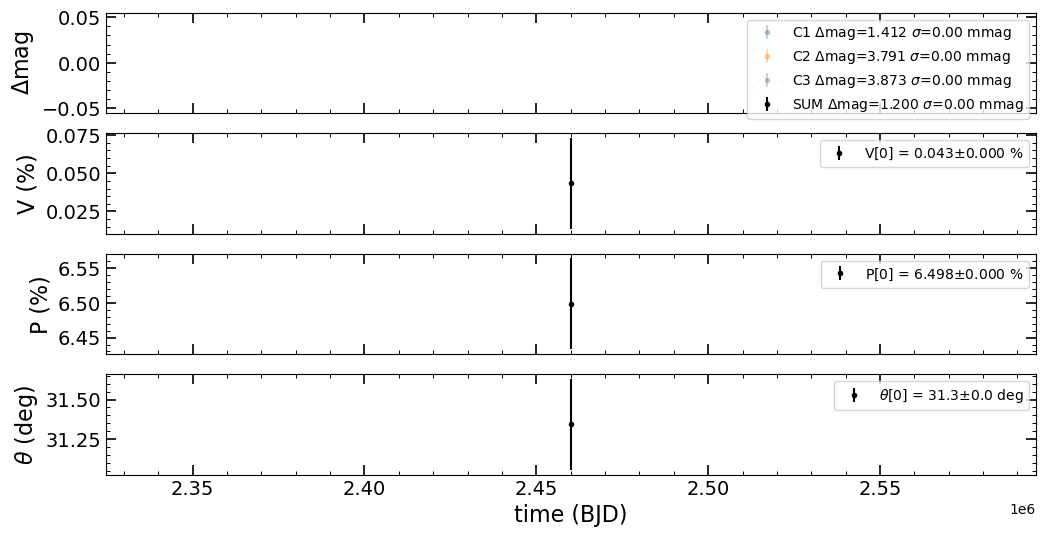

In [28]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)

## Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE` mode

In [22]:
# initial set up
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l4_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of quarter-wave files (L4)
pol_l4_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L4')

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')


5 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000045_stdpol.fits
OBJECT files: 16
Loading science frames to memory ... 
gain: 3.37 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 16 : 20230606_s4c1_000045_stdpol.fits 


/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if name in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  while col in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:

Calibrating science frame 2 of 16 : 20230606_s4c1_000041_stdpol.fits 


2023-11-24 14:52:08,993 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:08,995 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:08,996 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,137 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,138 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 3 of 16 : 20230606_s4c1_000035_stdpol.fits 


2023-11-24 14:52:09,379 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,381 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,382 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,532 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,534 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 4 of 16 : 20230606_s4c1_000044_stdpol.fits 


2023-11-24 14:52:09,784 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,786 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,787 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,931 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:09,933 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 5 of 16 : 20230606_s4c1_000036_stdpol.fits 


2023-11-24 14:52:10,172 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,173 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,175 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,316 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,317 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 6 of 16 : 20230606_s4c1_000039_stdpol.fits 


2023-11-24 14:52:10,539 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,540 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,542 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,686 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,687 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 7 of 16 : 20230606_s4c1_000048_stdpol.fits 


2023-11-24 14:52:10,918 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,919 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:10,920 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,062 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,064 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 8 of 16 : 20230606_s4c1_000038_stdpol.fits 


2023-11-24 14:52:11,292 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,293 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,294 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,436 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,437 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 9 of 16 : 20230606_s4c1_000047_stdpol.fits 


2023-11-24 14:52:11,667 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,668 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,669 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,810 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:11,811 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 10 of 16 : 20230606_s4c1_000040_stdpol.fits 


2023-11-24 14:52:12,046 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,047 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,048 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,190 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,191 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 11 of 16 : 20230606_s4c1_000043_stdpol.fits 


2023-11-24 14:52:12,424 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,425 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,427 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,562 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,564 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 12 of 16 : 20230606_s4c1_000037_stdpol.fits 


2023-11-24 14:52:12,796 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,797 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,798 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,935 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:12,936 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 13 of 16 : 20230606_s4c1_000042_stdpol.fits 


2023-11-24 14:52:13,178 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,179 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,181 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,330 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,331 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 14 of 16 : 20230606_s4c1_000050_stdpol.fits 


2023-11-24 14:52:13,557 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,558 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,559 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,695 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,697 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 15 of 16 : 20230606_s4c1_000049_stdpol.fits 


2023-11-24 14:52:13,933 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,934 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:13,935 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:14,073 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:14,074 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Calibrating science frame 16 of 16 : 20230606_s4c1_000046_stdpol.fits 


2023-11-24 14:52:14,305 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:14,306 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_value' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:14,307 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:14,445 astropy - WARNING - VerifyWarning: Keyword name 'astropop gain_corrected' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.  [logger]
2023-11-24 14:52:14,447 astropy - WARNING - VerifyWarning: Keyword name 'astropop

Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000045_stdpol.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000041_stdpol.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000035_stdpol.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000044_stdpol.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000036_stdpol.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000039_stdpol.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000048_stdpol.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000038_stdpol.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000047_stdpol.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/20230606_s4c1_000040_stdpol.fits
10 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230606/202

2023-11-24 14:52:14,694 astropop - INFO - Filling registered image with cval=10.37  [register]
2023-11-24 14:52:14,701 astropop - INFO - Registering image with: translation=[-0. -1.], rotation=0.00°  [register]
2023-11-24 14:52:14,946 astropop - INFO - Registering image 3 from 16  [register]
2023-11-24 14:52:15,049 astropop - INFO - Filling registered image with cval=10.14  [register]
2023-11-24 14:52:15,050 astropop - INFO - Registering image with: translation=[-0.75  1.  ], rotation=0.00°  [register]
2023-11-24 14:52:15,223 astropop - INFO - Registering image 4 from 16  [register]
2023-11-24 14:52:15,338 astropop - INFO - Filling registered image with cval=10.50  [register]
2023-11-24 14:52:15,348 astropop - INFO - Registering image with: translation=[-0.5   0.75], rotation=0.00°  [register]
2023-11-24 14:52:15,518 astropop - INFO - Registering image 5 from 16  [register]
2023-11-24 14:52:15,710 astropop - INFO - Filling registered image with cval=10.20  [register]
2023-11-24 14:52:1

Creating new catalog of detected sources:
Running photometry for multiple apertures:
Aperture radius of 5 pixels: 1 of 16 :
Aperture radius of 6 pixels: 2 of 16 :
Aperture radius of 7 pixels: 3 of 16 :
Aperture radius of 8 pixels: 4 of 16 :
Aperture radius of 9 pixels: 5 of 16 :
Aperture radius of 10 pixels: 6 of 16 :
Aperture radius of 11 pixels: 7 of 16 :
Aperture radius of 12 pixels: 8 of 16 :
Aperture radius of 13 pixels: 9 of 16 :
Aperture radius of 14 pixels: 10 of 16 :
Aperture radius of 15 pixels: 11 of 16 :
Aperture radius of 16 pixels: 12 of 16 :
Aperture radius of 17 pixels: 13 of 16 :


2023-11-24 14:52:21,649 astropy - WARNING - TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days  [logger]


Aperture radius of 18 pixels: 14 of 16 :
Aperture radius of 19 pixels: 15 of 16 :
Aperture radius of 20 pixels: 16 of 16 :
The 16 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000043_stdpol_proc.fits
2 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000036_stdpol_proc.fits
3 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000046_stdpol_proc.fits
4 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000050_stdpol_proc.fits
5 of 16 is reduced? True -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000035_stdpol_proc.fits
6 of 16 is reduced? True -> /Users/eder/Data/SPAR

/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/framedata/_compat.py:133: UserWarning: Duplicated key GFOC. First value will be used.
  warnings.warn(f'Duplicated key {k}. First value will be used.')
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if k in self.keywords or add_columns:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if item not in self.keywords:
/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/_db.py:63: FutureWarning: elementwise comparison 

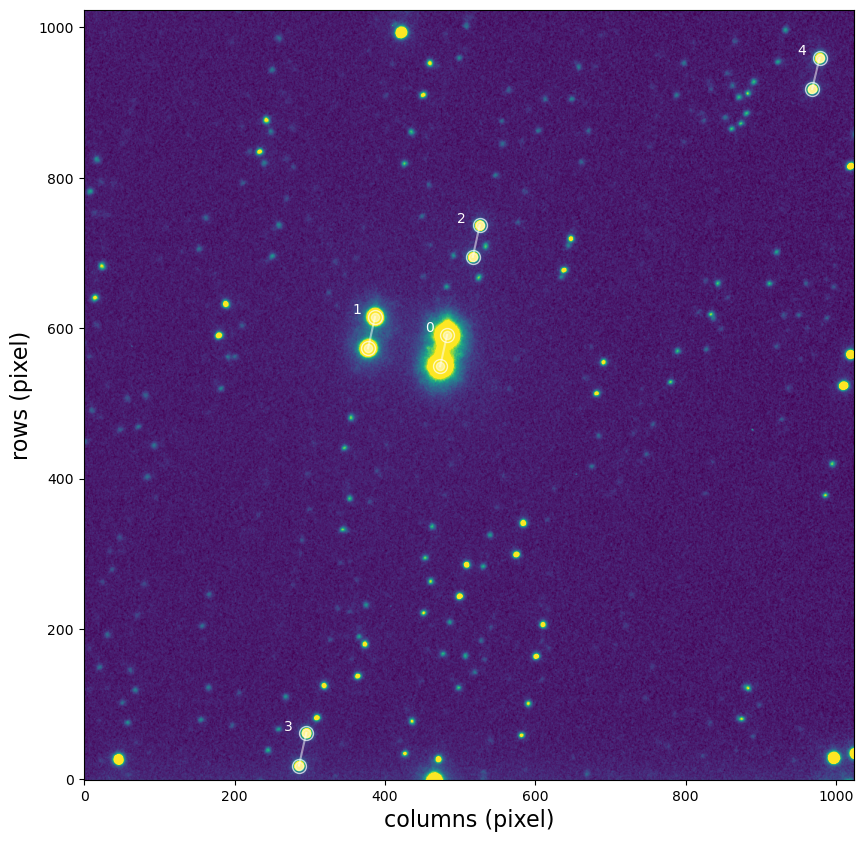

In [23]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l4_list,
                                          reducedir,
                                          stack_suffix=l4_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          verbose=True,
                                          plot=True) 

## Calculate `QUARTER-WAVE` POLARIMETRY

In [24]:
# input reduced files list
red_pol_l4_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l4_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l4_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


There is already a polarimetry product : /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1/20230606/20230606_s4c1_000035_stdpol_l4_polar.fits


2023-11-24 14:52:22,633 astropop - INFO - Normalization disabled.  [__init__]


Source index: i=0 
Source RA=280.2125492169785 Dec=-6.774857101269467 mag=-19.3665+-0.0001
Best aperture radius: 14.0 pixels
Polarization in Q: 0.0273+-0.0003
Polarization in U: 0.0584+-0.0005
Polarization in V: 0.0005+-0.0002
Total linear polarization p: 0.0645+-0.0005
Angle of polarization theta: 32.4+-0.2
Free constant k: 1+-nan
Zero of polarization: 50.9+-0.1
RMS of zi residuals: 0.00051
Reduced chi-square (n=16.0, DOF=12.0): 1.22


/Users/eder/anaconda3/lib/python3.11/site-packages/astropop/math/physical.py:99: RuntimeWarning: invalid value encountered in cast
  return -np.int_(np.floor(np.log10(np.abs(std)))) + sig - 1
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


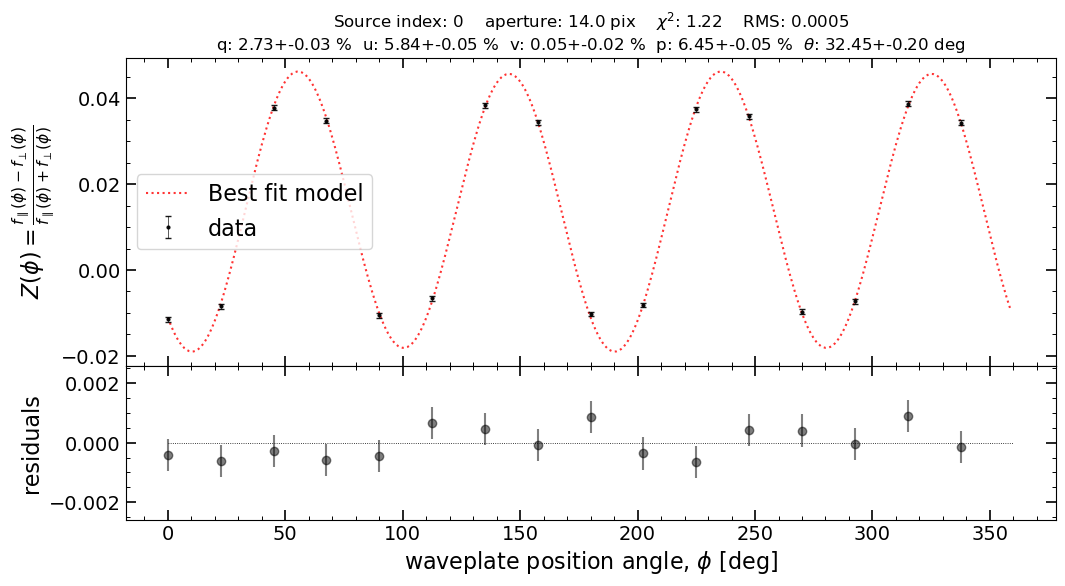

In [25]:
l4_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key='WPPOS',
                                                 wave_plate = 'quarterwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = False,
                                                 fit_zero = True,
                                                 force=FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    l4_polar_products.append(polarproduct)    

## Time series of `QUARTER-WAVE` polarimetry data

In [30]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)   

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l4_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

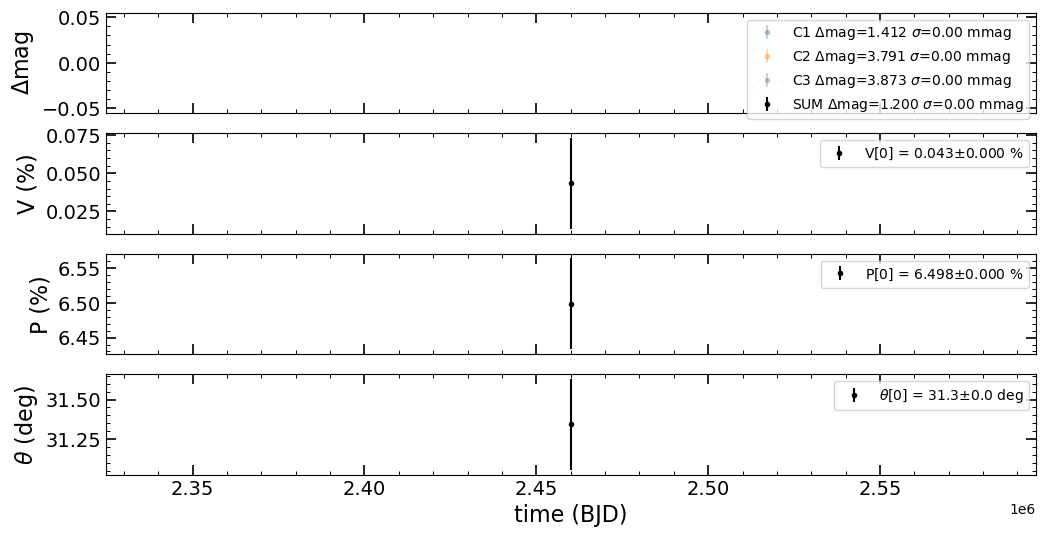

In [31]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)